In [8]:
import os
#import cv2
import math
import mpld3
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from copy import deepcopy
from urllib.request import urlretrieve
# from IPython.display import HTML, display

from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis, Box, 
                         Capsule, ContactResults, Concatenate, DiagramBuilder, LeafSystem,
                         InverseDynamicsController, LoadModelDirectives, MeshcatVisualizer, Parser,
                         PiecewisePolynomial, PiecewisePose, PointCloud, TrajectorySource, 
                         ProcessModelDirectives, RandomGenerator, BasicVector, SceneGraph, 
                         RigidTransform, RollPitchYaw, RotationMatrix, Simulator, StartMeshcat,
                         UniformlyRandomRotationMatrix, Rgba, ContactResults, BaseField, Fields,
                         ConstantVectorSource, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
                         MeshcatVisualizerParams, MultibodyPlant, MultibodyPositionToGeometryPose,
                         Quaternion, JointSliders, Rgba, Sphere, StateInterpolatorWithDiscreteDerivative)
from pydrake.common import FindResourceOrThrow, temp_directory
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.meshcat import JointSliders
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder

from manipulation import FindResource, running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.clutter import GenerateAntipodalGraspCandidate
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.pick import (MakeGripperCommandTrajectory, MakeGripperFrames,
                               MakeGripperPoseTrajectory)
from manipulation.scenarios import (AddIiwaDifferentialIK, 
                                    MakeManipulationStation, ycb, AddRgbdSensors)

# import torch
# import torch.utils.data
# import torchvision
# import torchvision.transforms.functional as Tf

# from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [9]:
# define the model paths
# 1. iiwa and camera
sketchbot_model_path = os.path.abspath("models/sketchbot.dmd.yaml")
# 2. objects
bunny_sdf_path = os.path.abspath("models/bunny.sdf")
bunny_data = f"""
- add_frame:
     name: bunny_origin
     X_PF:
         base_frame: world
         rotation: !Rpy {{ deg: [-90.0, 0.0, -90.0 ]}}
         translation: [1.75, 0, 0.09515]

- add_model:
     name: bunny
     file: file://{bunny_sdf_path}

- add_weld:
     parent: world
     child: bunny::bunny_center
"""
## write the bunny data to a file
with open("models/bunny.dmd.yaml", "w") as f:
    f.write(bunny_data)
bunny_model_path = os.path.abspath("models/bunny.dmd.yaml")
# canvas
canvas_sdf_path = os.path.abspath("models/canvas.sdf")
canvas_data = f"""
- add_model:
    name: canvas
    file: file://{canvas_sdf_path}
- add_weld:
    parent: world
    child: canvas::canvas_top_center  
"""
with open("models/canvas.dmd.yaml", "w") as f:
    f.write(canvas_data)
canvas_model_path = os.path.abspath("models/canvas.dmd.yaml")

def create_scene_data(model_directives_files: list) -> str:
    """Create the scene data for the sketchbot.
       Returns a string containing the scene data.
    """
    model_directives = ""
    for directive in model_directives_files:
        with open(directive, "r") as f:
            model_directives += f.read()
    return model_directives

sketchbot_directives = create_scene_data([sketchbot_model_path, bunny_model_path, canvas_model_path])
# print(sketchbot_directives)
        
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [10]:
class MeshcatWriter(LeafSystem):
    def __init__(self, meshcat, drawing_body_index, canvas_body_index,
                    rgba, line_width=0.01, draw_threshold=0.01):
        LeafSystem.__init__(self)
        self._meshcat = meshcat
        self._drawing_body_index = drawing_body_index
        self._canvas_body_index = canvas_body_index
        self._rgba = rgba
        self._line_width = line_width
        self._draw_threshold = draw_threshold

        self.DeclareAbstractInputPort("contact_results",
                                        AbstractValue.Make(ContactResults()))
        self.DeclarePeriodicDiscreteUpdateEvent(0.01, 0, self.MaybeDraw)

        self._p_WLastDraw_index = self.DeclareDiscreteState(3)
        self._was_in_contact_index = self.DeclareDiscreteState([0])
        self._num_drawn_index = self.DeclareDiscreteState([0])

    def MaybeDraw(self, context, discrete_state):
        results = self.get_input_port().Eval(context)

        # The point on the canvas that most deeply penetrates the chalk.
        p_WDraw = None
        for i in range(results.num_point_pair_contacts()):
            info = results.point_pair_contact_info(i)
            if (info.bodyA_index() == self._drawing_body_index and
                    info.bodyB_index() == self._canvas_body_index):
                p_WDraw = info.point_pair().p_WCb
                break
            elif (info.bodyA_index() == self._drawing_body_index and
                    info.bodyB_index() == self._canvas_body_index):
                p_WDraw = info.point_pair().p_WCa
                break

        if p_WDraw is not None:
            p_WLastDraw = context.get_discrete_state(
                self._p_WLastDraw_index).get_value()
            was_in_contact = context.get_discrete_state(
                self._was_in_contact_index)[0]
            num_drawn = context.get_discrete_state(self._num_drawn_index)[0]

            length = np.linalg.norm(p_WDraw - p_WLastDraw)
            if (was_in_contact and length > self._draw_threshold):
                meshcat.SetObject(f"writer/{num_drawn}",
                                    Capsule(self._line_width, length),
                                    self._rgba)
                p_WMidpoint = (p_WDraw + p_WLastDraw)/2
                X_WCapsule = RigidTransform(
                    RotationMatrix.MakeFromOneVector(
                        p_WDraw - p_WLastDraw, 2), p_WMidpoint)
                meshcat.SetTransform(f"writer/{num_drawn}", X_WCapsule)
                discrete_state.set_value(self._num_drawn_index,
                                            [num_drawn + 1])
                discrete_state.set_value(self._p_WLastDraw_index, p_WDraw)
            elif not was_in_contact:
                discrete_state.set_value(self._p_WLastDraw_index, p_WDraw)

            discrete_state.set_value(self._was_in_contact_index, [1])
        else:
            discrete_state.set_value(self._was_in_contact_index, [0])

In [11]:
#Creating small leaf system that takes a trajectory and provides one pose at a time. 
class PoseSystem(LeafSystem):
    def __init__(self, plant, traj):
        LeafSystem.__init__(self)
        port = self.DeclareAbstractOutputPort("pose", lambda: AbstractValue.Make(RigidTransform()), self.DoCalcOutput)
        self.traj = traj 
    
    def DoCalcOutput(self, context, output):
        """Constructs the output pose based on the trajectory that was passed in."""
        output.set_value(self.traj.GetPose(context.get_time()))

In [12]:
#Pseudoinverse Controller (DiffIK imported through AddIiwaDifferentialIK)
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_G", BasicVector(6))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(self._plant_context, JacobianWrtVariable.kV, self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G) #important
        output.SetFromVector(v)

In [13]:
#Painter Class
class IIWA_Painter():
    def __init__(self, traj1=None, traj2 = None):
        meshcat.Delete()
        meshcat.DeleteAddedControls()
        builder = DiagramBuilder()
        
        # set up the system of manipulation station
        self.station = MakeManipulationStation(model_directives = sketchbot_directives, 
                                               time_step=0.001)
        #, package_xmls=["models/package.xml"]

        builder.AddSystem(self.station)
        self.plant = self.station.GetSubsystemByName("plant")
        
        if traj1 is not None:
            """ This is the trajectory for the iiwa arm """
            ## DO NOT DELETE ###### PSEUDOINVERSE CONTROLLER ##############  
            # traj1_V_G = traj1.MakeDerivative()
            # V_G_source1 = builder.AddSystem(TrajectorySource(traj1_V_G))
            

            # self.controller = builder.AddSystem(PseudoInverseController(self.plant))
            # builder.Connect(V_G_source1.get_output_port(), self.controller.GetInputPort("V_G"))

            # self.integrator = builder.AddSystem(Integrator(7))
            # builder.Connect(self.controller.get_output_port(), self.integrator.get_input_port())
            # builder.Connect(self.integrator.get_output_port(), self.station.GetInputPort("iiwa_position"))
            # builder.Connect(self.station.GetOutputPort("iiwa_position_measured"), self.controller.GetInputPort("iiwa_position"))
            # ##############################################


            # ### DO NOT DELETE ##### Diff IK CONTROLLER ############## 
            pose_picker = builder.AddSystem(PoseSystem(self.plant, traj))
            self.robot = self.station.GetSubsystemByName("iiwa_controller").get_multibody_plant_for_control()

            # Set up differential inverse kinematics.
            self.diff_ik = AddIiwaDifferentialIK(builder, self.robot)
            
            builder.Connect(self.diff_ik.get_output_port(), self.station.GetInputPort("iiwa_position"))
            
            builder.Connect(pose_picker.get_output_port(), self.diff_ik.get_input_port(0)) #should this be velocity or position? 
            builder.Connect(self.station.GetOutputPort("iiwa_state_estimated"), self.diff_ik.GetInputPort("robot_state"))
            # ###############################################

        if traj2 is not None:
            """
            This is the gripper trajectory. 
            """
            wsg_position = builder.AddSystem(TrajectorySource(traj2))
            builder.Connect(wsg_position.get_output_port(), self.station.GetInputPort("wsg_position"))
           
        ############## IMPLEMENTING DRAWING ##################
        # self.writer = builder.AddSystem(MeshcatWriter(meshcat,
        #               self.plant.GetBodyByName("cylinder_link").index(),
        #               self.plant.GetBodyByName("paper_link").index(),
        #               Rgba(0, 0, 0, 1.0), line_width=0.003))

        # builder.Connect(self.station.GetOutputPort("contact_results"), self.writer.get_input_port())
        #####################################################

        params = MeshcatVisualizerParams()
        params.delete_on_initialization_event = False
        self.visualizer = MeshcatVisualizer.AddToBuilder(builder, self.station.GetOutputPort("query_object"), meshcat, params)

        self.diagram = builder.Build()
        self.gripper_frame = self.plant.GetFrameByName('body')
        self.world_frame = self.plant.world_frame()
        context = self.CreateDefaultContext()
        
        #################### CAMERA STUFF ########################
        diagram_context = self.station.CreateDefaultContext() #get the context for the entire manipulation station. 

        depth_im_read = self.station.GetOutputPort("camera0_depth_image").Eval(diagram_context).data.squeeze() #change to camera_context 
        self.depth_im = deepcopy(depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        self.rgb_im = self.station.GetOutputPort("camera0_rgb_image").Eval(diagram_context).data
        self.label_im = self.station.GetOutputPort('camera0_label_image').Eval(diagram_context).data.squeeze()
        self.mask = self.label_im == 1
        point_cloud = self.station.GetOutputPort("camera0_point_cloud").Eval(diagram_context)

        # Get other info about the camera
        self.cam = self.station.GetSubsystemByName("camera0")
        cam_context = self.cam.GetMyMutableContextFromRoot(context)
        self.X_WC = self.cam.body_pose_in_world_output_port().Eval(cam_context)
        self.X_WC = RigidTransform(self.X_WC)
        self.cam_info = self.cam.depth_camera_info()

    def visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        AddMeshcatTriad(meshcat, "painter/" + name,length=length, radius=radius, X_PT=X_WF)

    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, context)
        station_context = self.diagram.GetMutableSubsystemContext(self.station, context)

        # provide initial states
        q0 = np.array([ 1.40666193e-05,  1.56461165e-01, -3.82761069e-05,
                       -1.32296976e+00, -6.29097287e-06,  1.61181157e+00, -2.66900985e-05])
        
        # set the joint positions of the kuka arm
        iiwa = self.plant.GetModelInstanceByName("iiwa")
        self.plant.SetPositions(plant_context, iiwa, q0)
        self.plant.SetVelocities(plant_context, iiwa, np.zeros(7))
        wsg = self.plant.GetModelInstanceByName("wsg")
        self.plant.SetPositions(plant_context, wsg, [-0.005,0.005]) #-0.05, 0.05])
        self.plant.SetVelocities(plant_context, wsg, [0, 0])        

        if hasattr(self, 'integrator'):
            self.integrator.set_integral_value(
                self.integrator.GetMyMutableContextFromRoot(context), q0)

        return context

    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
                    plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG

    def paint(self, sim_duration=20.0):
        context = self.CreateDefaultContext()
        simulator = Simulator(self.diagram, context)
        simulator.set_target_realtime_rate(1.0)

        duration = sim_duration if running_as_notebook else 0.01
        simulator.AdvanceTo(duration)

    def project_depth_to_pC(self, depth_pixel):
        v = depth_pixel[:,0]
        u = depth_pixel[:,1]
        Z = depth_pixel[:,2]
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u-cx) * Z/fx
        Y = (v-cy) * Z/fy
        pC = np.c_[X,Y,Z]
        return pC
    
    def visualize_key_frames(self, frame_poses):
        for i, pose in enumerate(frame_poses):
            self.visualize_frame('frame_{}'.format(i), pose, length=0.05)

In [14]:
p0 = [0.45, 0.0, 0.2]
R0 = RotationMatrix(np.array([[0, 1, 0], [0, 0, -1], [-1, 0, 0]]).T)
X_WorldCenter = RigidTransform(R0, p0)



painter = IIWA_Painter()
X_WG = painter.get_X_WG()
painter.visualize_frame('gripper_current', X_WG)

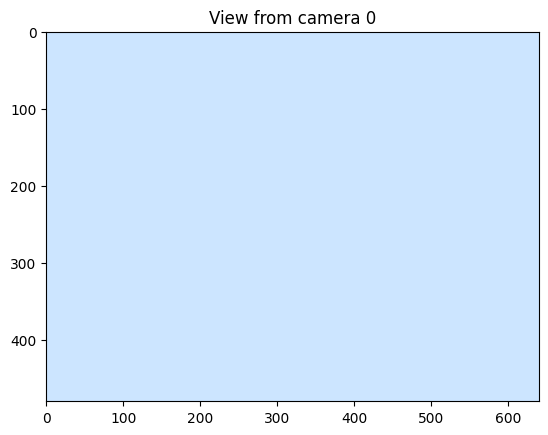

In [15]:
from PIL import Image

plt.imshow(painter.rgb_im)
plt.title("View from camera 0")
plt.show()